In [0]:
# Checking if archive is downloaded in memory.
try:
    dbutils.fs.ls("file:/databricks/driver/dblp.v13.7z")
    print("Archive in filesystem (file:/databricks/driver/dblp.v13.7z)")
except:
    # If archive is not in memory, Checking databricks store for cached version and pulling into memory.
    try:
        dbutils.fs.ls("dbfs:/FileStore/data/dblp.v13.7z")
        print("Archive located in FileStore. Copying into local store..")
        dbutils.fs.cp("dbfs:/FileStore/data/dblp.v13.7z", "file:/databricks/driver/dblp.v13.7z")
        print("Completed")
    except:
        # If archive is not cached, downloading and storing in databricks store.
        print("7z archive not found. Fetching from URL...")
        !wget https://originalstatic.aminer.cn/misc/dblp.v13.7z
        print("7z archive Downloaded. Moving archive to FileStore..")
        dbutils.fs.mkdirs("dbfs:/FileStore/data")
        dbutils.fs.cp("file:/databricks/driver/dblp.v13.7z", "dbfs:/FileStore/data/dblp.v13.7z")
        print("Completed.")

7z archive not found. Fetching from URL...
--2023-05-29 18:02:03--  https://originalstatic.aminer.cn/misc/dblp.v13.7z
Resolving originalstatic.aminer.cn (originalstatic.aminer.cn)... 159.27.2.14
Connecting to originalstatic.aminer.cn (originalstatic.aminer.cn)|159.27.2.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2568255035 (2.4G) [application/x-7z-compressed]
Saving to: ‘dblp.v13.7z’

dblp.v13.7z

*** WARNING: max output size exceeded, skipping output. ***

dblp.v13.7z         100%[===================>]   2.39G  17.4MB/s    in 2m 40s  

2023-05-29 18:04:44 (15.3 MB/s) - ‘dblp.v13.7z’ saved [2568255035/2568255035]

7z archive Downloaded. Moving archive to FileStore..
Completed.


In [0]:
# Show details

dbutils.fs.ls("file:/databricks/driver/dblp.v13.7z")

Out[2]: [FileInfo(path='file:/databricks/driver/dblp.v13.7z', name='dblp.v13.7z', size=2568255035, modificationTime=1631501339000)]

In [0]:
#Extracting 7zip file into json.

!pip install py7zr -q

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-09833915-331d-4067-876f-1d1e0f88ef39/bin/python -m pip install --upgrade pip' command.


In [0]:
import py7zr

archive = py7zr.SevenZipFile('dblp.v13.7z', mode='r')
archive.extractall()
archive.close()

In [0]:
dbutils.fs.ls("file:/databricks/driver/dblpv13.json")

Out[5]: [FileInfo(path='file:/databricks/driver/dblpv13.json', name='dblpv13.json', size=17352640799, modificationTime=1631240655155)]

In [0]:
#Cleaning NumberInt(#) tags
import re

fin = open(f"dblpv13.json")
fout = open(f"dblpv13_clean.json", "wt")
for line in fin:
    fout.write(re.sub(r"NumberInt\([\d]*\)", lambda x: "".join(re.findall(r"\d", x.group(0))), line))
fin.close()
fout.close()

In [0]:
%mkdir data

In [0]:
pip install ijson

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import ijson
import json
import decimal

class DecimalEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, decimal.Decimal):
            return str(o)
        return super(DecimalEncoder, self).default(o)

data_dir = 'data/'
with open('dblpv13_clean.json', 'r') as f:
    counter, file_id = 0, 0
    file_buffer = []
    for obj_data in ijson.items(f, 'item'):
        file_buffer.append(obj_data)
        counter += 1
        if counter % 300000 == 0:
            print(f" Saving, data_PART_{file_id}.json in {data_dir}")
            f = open(f'{data_dir}data_PART_{file_id}.json', 'w')
            dump = json.dumps(file_buffer, cls=DecimalEncoder)
            f.write(dump)
            f.close()
            file_id += 1
            file_buffer = []
f = open(f'{data_dir}data_PART_{file_id}.json', 'w')
dump = json.dumps(file_buffer, cls=DecimalEncoder)
print(f" Saving, data_PART_{file_id}.json in {data_dir}")
f.write(dump)
f.close()
file_id += 1
file_buffer = []

 Saving, data_PART_0.json in data/
 Saving, data_PART_1.json in data/
 Saving, data_PART_2.json in data/
 Saving, data_PART_3.json in data/
 Saving, data_PART_4.json in data/
 Saving, data_PART_5.json in data/
 Saving, data_PART_6.json in data/
 Saving, data_PART_7.json in data/
 Saving, data_PART_8.json in data/
 Saving, data_PART_9.json in data/
 Saving, data_PART_10.json in data/
 Saving, data_PART_11.json in data/
 Saving, data_PART_12.json in data/
 Saving, data_PART_13.json in data/
 Saving, data_PART_14.json in data/
 Saving, data_PART_15.json in data/
 Saving, data_PART_16.json in data/
 Saving, data_PART_17.json in data/


In [0]:
# removing old json stored in filestore.
dbutils.fs.rm("dbfs:/FileStore/data/split_data/", recurse = True)
# Creating dir to store json in filestore..
dbutils.fs.mkdirs("dbfs:/FileStore/data/split_data")
# confirming dir is empty
dbutils.fs.ls("dbfs:/FileStore/data/split_data")

Out[2]: []

In [0]:
# Copying all json parts into filestore.
dbutils.fs.cp("file:/databricks/driver/data/", "dbfs:/FileStore/data/split_data", recurse = True)

Out[3]: True

In [0]:
output = dbutils.fs.ls("dbfs:/FileStore/data/split_data/") 
print(output)

[FileInfo(path='dbfs:/FileStore/data/split_data/data_PART_0.json', name='data_PART_0.json', size=655227048, modificationTime=1685386915000), FileInfo(path='dbfs:/FileStore/data/split_data/data_PART_1.json', name='data_PART_1.json', size=732826251, modificationTime=1685387089000), FileInfo(path='dbfs:/FileStore/data/split_data/data_PART_10.json', name='data_PART_10.json', size=671464495, modificationTime=1685386865000), FileInfo(path='dbfs:/FileStore/data/split_data/data_PART_11.json', name='data_PART_11.json', size=703358204, modificationTime=1685387066000), FileInfo(path='dbfs:/FileStore/data/split_data/data_PART_12.json', name='data_PART_12.json', size=754705228, modificationTime=1685387114000), FileInfo(path='dbfs:/FileStore/data/split_data/data_PART_13.json', name='data_PART_13.json', size=812317078, modificationTime=1685386840000), FileInfo(path='dbfs:/FileStore/data/split_data/data_PART_14.json', name='data_PART_14.json', size=829295893, modificationTime=1685387238000), FileInfo(

In [0]:
import uuid
from functools import reduce
from pyspark.sql import Row
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, IntegerType
from typing import List
from pyspark.sql.functions import udf

# Here Path indicates input file path, and delta_dir points to file
path = "dbfs:/FileStore/data/split_data/"
delta_dir = "dbfs:/delta/tables/"

# There should be 18 files each with 300 k records. This would change if you change split value.
file_count = len(dbutils.fs.ls(path))
assert file_count == 18, "Data not found. You may want to check the path or run the notebook from start again.  If you updated the split value, ignore this assertion error"

In [0]:
# Reading first chunk for Testing
union = spark.read.option("inferSchema", True).json(f"{path}data_PART_0.json")


# union = spark.readStream.schema(jsonSchema).option("maxFilesPerTrigger", 1).json(path)

union = union.na.drop(subset=["authors"])
union = union.dropDuplicates(["_id"])
union = union.filter(union.lang == 'en')
union = union.na.drop(subset=["title", "abstract"])
union.printSchema()

root
 |-- _id: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _id: string (nullable = true)
 |    |    |-- bio: string (nullable = true)
 |    |    |-- email: string (nullable = true)
 |    |    |-- gid: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- name_zh: string (nullable = true)
 |    |    |-- oid: string (nullable = true)
 |    |    |-- oid_zh: string (nullable = true)
 |    |    |-- orcid: string (nullable = true)
 |    |    |-- org: string (nullable = true)
 |    |    |-- org_zh: string (nullable = true)
 |    |    |-- orgid: string (nullable = true)
 |    |    |-- orgs: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- orgs_zh: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- sid: string (nullable = true)
 |-- doi: string (nulla

In [0]:
union.show()

+--------------------+--------------------+--------------------+--------------------+----+-------------+--------------------+-----+--------------------+----+----------+------------+------------+--------------------+----------+-------------+--------------------+--------------------+-------------+----+
|                 _id|            abstract|             authors|                 doi| fos|         isbn|                issn|issue|            keywords|lang|n_citation|    page_end|  page_start|                 pdf|references|        title|                 url|               venue|       volume|year|
+--------------------+--------------------+--------------------+--------------------+----+-------------+--------------------+-----+--------------------+----+----------+------------+------------+--------------------+----------+-------------+--------------------+--------------------+-------------+----+
|53e99784b7602d970...|360° represents t...|[{53f46946dabfaec...|10.1145/1665137.1...|null|    

In [0]:
# Deleting entries with small Titles (less than 3 words) and empty author list
text_size_ = udf(lambda s: len(s.split()), IntegerType())
arr_len_ = udf(lambda s: len(s), IntegerType())
union = union.filter(text_size_(F.col("Title")) > 3)

In [0]:
#Data preprocessing
!pip install spacy unidecode contractions nltk tqdm -q
!spacy download en_core_web_md

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-42406cc5-499b-4e02-9f76-55ab02c10052/bin/python -m pip install --upgrade pip' command.
     |██▋                             | 3.5 MB 5.7 MB/s eta 0:0

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 42.8 MB 239 kB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-42406cc5-499b-4e02-9f76-55ab02c10052/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [0]:
stopwords = ['https', 'table', 'index', 'peer', 'peers', 'reviewed', 'copyright', 'copyrights', 'authors', 'author', 'figure','fig', 'fig.', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'rights', 'reserved', 'Elsevier', 'PMC', 'CZI', 'www', 'i.e.', 'et', 'org', 'al', 's', 'preprint', 'present', 'paper', 'papers']


In [0]:
pip install contractions

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import re
import spacy
import nltk
from tqdm import tqdm
import unidecode
import contractions
from nltk.stem import WordNetLemmatizer
from pyspark.ml.feature import Word2Vec
from pyspark.ml.clustering import KMeans

en = spacy.load('en_core_web_md')
sw_spacy = set(en.Defaults.stop_words)

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

sw_spacy = list(sw_spacy) + stopwords

numIterations = 200

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [0]:
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

def preprocess_udf():
    def preprocess(title, abstract):
        tokens = []
        # cleaning symbols
        if title:
            title = re.sub(r"[^A-Za-z]+", " ", title)
            title = remove_accented_chars(title)
            title = expand_contractions(title)
            tokens = [lemmatizer.lemmatize(word.lower()) for word in title.split() if word.lower() not in sw_spacy]
        if abstract:
            # cleaning symbols
            abstract = re.sub(r"[^A-Za-z ]+", "", abstract)
            # removing accented characters (required?)
            abstract = remove_accented_chars(abstract)
            abstract = expand_contractions(abstract)
            tokens += [lemmatizer.lemmatize(word.lower()) for word in abstract.split() if word.lower() not in sw_spacy]
        return tokens
    return udf(preprocess, ArrayType(StringType()))

In [0]:
union = union.withColumn("tokens", preprocess_udf()("abstract", "title"))

documents = union.select("_id", "tokens").filter(arr_len_(F.col("tokens")) > 0)

In [0]:
display(documents)

_id tokens 53e99792b7602d9701f5b114 List(positive, feedback, pilot, system, second, loop, control, feedforward, power, amplifier) 53e99792b7602d9701f5b191 List(human, sensibility, ergonomics, hse, apprehend, human, sensitivity, feature, measuring, human, sens, developing, table, related, psychology, physiology, main, purpose, hse, developing, human, centered, good, environment, relevant, technology, improved, life, quality, order, achieve, goal, test, bed, simulator, useful, tool, controlling, monitoring, physical, environment, deal, requirement, design, concept, specification, computing, environment, hse, hse, technology, development, program, sponsored, korean, ministry, science, technology, integrated, computing, system, composed, real, time, non, real, time, environment, non, real, time, development, environment, comprises, pc, window, nt, graphical, user, interface, coded, microsoft, visual, c, pc, independently, control, monitor, thermal, light, audio, video, environment, software, database, developed, non, real, time, environment, directly, ported, real, time, environment, local, area, network, real, time, computing, system, based, cpci, bus, control, integrated, hse, environment, collect, necessary, information, cpci, computing, system, composed, pentium, cpu, board, dedicated, o, board, quantity, determined, expandability, considered, integrated, computing, environment, hse, simulator, guarantee, real, time, capability, stability, expandability, hardware, maximize, portability, compatibility, maintainability, software, requirement, analysis, design, computational, environment, hse, humansensibility, ergonomics, simulator) 53e99792b7602d9701f5b2d3 List(present, novel, ia, instrumentation, amplifier, design, implantable, biomedical, device, system, db, cmrr, common, mode, rejection, ratio, proposed, ia, composed, stage, including, preamplifier, nd, order, bpf, band, pas, filer, dc, level, shifter, output, buffer, stage, low, noise, gm, c, amplifier, preamplifier, stage, reduce, coupled, thermal, noise, overwhelm, weak, neural, signal, bpf, designed, based, ota, operational, transconductance, amplifier, dual, current, switch, aiming, low, power, low, noise, demand, source, follower, employed, carry, dc, level, shifter, output, buffer, provides, output, signal, adequate, drive, following, stage, usually, adc, analog, digital, converter, detailed, analysis, proposed, circuitry, derived, solidify, proposed, architecture, proposed, design, implemented, tsmc, mum, p, m, cmos, process, result, post, layout, simulation, verify, performance, design, cmrr, better, db, important, input, noise, rms, merely, db, pvt, process, supply, voltage, temperature, corner, db, cmrr, lownoise, instrumentation, amplifier, neural, signal, sensing) 53e99792b7602d9701f5b391 List(prototyping, development, environment, graphical, interactive, telematic, application) 53e99792b7602d9701f5b3e5 List(augmented, reality, technology, overlay, virtual, image, information, generated, computer, real, scene, technology, combine, virtual, object, real, world, put, forward, registration, method, multi, marker, augmented, system, paleontology, magic, book, designed, realized, book, special, virtual, education, interactive, real, time, end, result, showed, study, prosperous, future, augmented, reality, applying, education, seen, method, multiplemarker, register, application, virtual, education) 53e99792b7602d9701f5b3f3 List(abstract, industrial, research, project, demonstrated, feasibility, applying, category, theoretic, method, specification, synthesis, maintenance, industrial, strength, software, system, demonstration, kind, tool, purpose, kestrel, specware, software, development, system, describe, experience, discus, broadening, application, category, theoretic, method, industry, technology, promising, need, additional, development, generally, usable, surprising, given, mathematical, foundation, hand, believe, demonstration, turning, point, use, mathematically,

In [0]:
#word2vec
word2Vec = Word2Vec(inputCol="tokens", outputCol="features").fit(documents)
documents = word2Vec.transform(documents)

In [0]:
display(documents)

_id tokens features 53e99792b7602d9701f5b114 List(positive, feedback, pilot, system, second, loop, control, feedforward, power, amplifier) Map(vectorType -> dense, length -> 100, values -> List(-0.004355446621775627, 0.09880385138094426, 0.15034013874828817, -0.0953014986589551, 0.021974068321287635, -0.06931450609117747, 0.11809404771775008, -0.022198732942342758, 0.15011485014110804, 0.011881736386567355, -0.09552902653813362, -0.14280216027400458, 0.05023348453687504, 0.06794802211225033, 0.046421220526099205, 0.13425394520163536, -0.20112161980941892, -0.059638644102960825, -0.09882525028660893, -0.00778913013637066, 0.07057288486976177, 0.017931670509278776, 0.09975282438099385, -0.009655201435089113, 0.035358195006847386, 0.06044814102351666, 0.02233057152479887, -0.2019486002624035, -0.11168549340218306, 0.2298132471740246, -0.07830424048006535, -0.23613754604011775, 0.005828802846372128, 0.18344137911917643, 0.1178610697388649, 0.10919363654975314, -0.040190265327692036, -0.15150000825524332, -0.1726626859046519, -0.2613553922623396, 0.04799652360379696, 0.028801769367419183, -0.18607864470686764, 0.03608828447759151, -0.06454984773881733, -0.06338197477161885, -0.002876662276685238, 0.0908568311482668, -0.04268607953563333, 0.03534447457641363, -5.683384370058775E-6, 0.03150951338466257, 0.048773858696222305, -0.05971459455322475, 0.18839896693825722, -0.015802451968193056, 0.08066799119114876, -0.045954798161983494, 0.08944591470062734, -0.02849094271659851, -0.0047980772331357, -0.14453256144188345, -0.009857255965471268, -0.014229957945644855, 0.280581720545888, 0.13663879893720152, -0.18303806689800695, -0.04345592362806201, 0.13256184682250025, -0.08031873051077128, 0.026306699216365817, -0.12424708008766175, -0.1578953005373478, -0.05659602172672749, 0.022693801298737527, 0.1647602140903473, 0.03097177166491747, 0.02559762354940176, -0.009938198584131898, -0.05170984994620085, 0.09286304553970695, -0.010629572439938784, -0.07147479820996523, 0.003666665777564049, -0.12595097441226244, 0.05663097007200122, -0.06085347915068269, -0.31219812482595444, 0.08285737568512559, 0.10782212000340224, -0.09104046300053598, -0.0025725731626152996, -0.1429218217730522, -0.24983539003878832, 0.02164132297039032, 0.16185606643557549, 0.1967209380120039, -0.15921784639358522, 0.018317532166838648, 0.053657144680619245)) 53e99792b7602d9701f5b191 List(human, sensibility, ergonomics, hse, apprehend, human, sensitivity, feature, measuring, human, sens, developing, table, related, psychology, physiology, main, purpose, hse, developing, human, centered, good, environment, relevant, technology, improved, life, quality, order, achieve, goal, test, bed, simulator, useful, tool, controlling, monitoring, physical, environment, deal, requirement, design, concept, specification, computing, environment, hse, hse, technology, development, program, sponsored, korean, ministry, science, technology, integrated, computing, system, composed, real, time, non, real, time, environment, non, real, time, development, environment, comprises, pc, window, nt, graphical, user, interface, coded, microsoft, visual, c, pc, independently, control, monitor, thermal, light, audio, video, environment, software, database, developed, non, real, time, environment, directly, ported, real, time, environment, local, area, network, real, time, computing, system, based, cpci, bus, control, integrated, hse, environment, collect, necessary, information, cpci, computing, system, composed, pentium, cpu, board, dedicated, o, board, quantity, determined, expandability, considered, integrated, computing, environment, hse, simulator, guarantee, real, time, capability, stability, expandability, hardware, maximize, portability, compatibility, maintainability, software, requirement, analysis, design, computational, environment, hse, humansensibility, ergonomics, simulator) Map(vectorType -> dense, length -> 100, values -> List(0.05102191527408582, 0.02963698427710268, -0.03256087864

In [0]:
# K-means clustering. 
costs = {}

for k in tqdm(range(30, 65, 10)):
    kmeans_model = KMeans(maxIter=numIterations, k=k, seed=100).fit(documents)
    costs[k] = kmeans_model.summary.trainingCost
    print(k, costs[k])
    


 25%|██▌       | 1/4 [30:30<1:31:32, 1830.69s/it]

30 87430.67220625553


 50%|█████     | 2/4 [1:00:39<1:00:36, 1818.11s/it]

40 83816.60685514774


 75%|███████▌  | 3/4 [1:31:37<30:36, 1836.31s/it]  

50 80907.83604912374


100%|██████████| 4/4 [2:03:32<00:00, 1853.04s/it]

60 78850.40381008553


In [0]:
kmeans_models.append(kmeans_model) 

In [0]:
costs

Out[77]: {30: 87430.67220625553,
 40: 83816.60685514774,
 50: 80907.83604912374,
 60: 78850.40381008553}

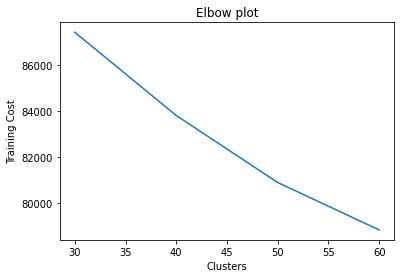

In [0]:
import matplotlib.pyplot as plt

x = list(costs.keys())
y = list(costs.values())

plt.plot(x, y)
plt.xlabel("Clusters")
plt.ylabel("Training Cost")
plt.title("Elbow plot")
plt.show()



In [0]:
import numpy as np
from pyspark.ml.clustering import KMeansModel


best_k = kmeans_models[0]  # Assuming there is only one model in the list
print(best_k)
# best_k.save("dbfs:/FileStore/data/clustering_model")





KMeansModel: uid=KMeans_9f07f629321b, k=60, distanceMeasure=euclidean, numFeatures=100


In [0]:
best_model = KMeansModel.load("dbfs:/FileStore/data/clustering_model")
predictions = best_model.transform(documents)
predictions.show()

+--------------------+--------------------+--------------------+----------+
|                 _id|              tokens|            features|prediction|
+--------------------+--------------------+--------------------+----------+
|53e99792b7602d970...|[positive, feedba...|[-0.0043554466217...|         2|
|53e99792b7602d970...|[human, sensibili...|[0.05102191527408...|        31|
|53e99792b7602d970...|[present, novel, ...|[0.03416896349342...|        36|
|53e99792b7602d970...|[prototyping, dev...|[0.22570125865084...|        35|
|53e99792b7602d970...|[augmented, reali...|[0.10296159282464...|        35|
|53e99792b7602d970...|[abstract, indust...|[0.09742034705781...|        48|
|53e99796b7602d970...|[address, problem...|[0.01205931911562...|        27|
|53e99796b7602d970...|[describes, new, ...|[0.00962072899982...|        31|
|53e99796b7602d970...|[power, distribut...|[0.02863145224788...|        26|
|53e99796b7602d970...|[existing, medica...|[0.04718322455883...|        42|
|53e99796b76